In [47]:
import pandas as pd
import numpy as np
import datetime as dp

#Library for visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import folium 
from folium.plugins import StripePattern
import branca.colormap
from collections import defaultdict
from folium.plugins import HeatMap

In [48]:
# Change the product name to english
products = pd.read_csv("olist_products_dataset.csv")
prod_cat_name_tr = pd.read_csv("product_category_name_translation.csv")
products = products.merge(prod_cat_name_tr, on='product_category_name', how='left')
products.drop ('product_category_name', axis=1, inplace=True)
#load all the tables
o_items = pd.read_csv("olist_order_items_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
o_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
geoloc = pd.read_csv("olist_geolocation_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
o_payments = pd.read_csv("olist_order_payments_dataset.csv")
customers = pd.read_csv("olist_customers_dataset.csv")

# Join the needed table
df = orders.merge(o_items, on='order_id', how='left')
df = df.merge(o_payments, on='order_id', how='outer', validate='m:m')
df = df.merge(products, on='product_id', how='outer')
df = df.merge(customers, on='customer_id', how='outer')
df = df.merge(sellers, on='seller_id', how='outer')


In [49]:
# remove columns yang tidak butuh
df = df.drop(axis=1,
columns=['product_name_lenght',
'product_description_lenght',
'product_photos_qty',
'product_weight_g',
'product_length_cm',
'product_height_cm',
'product_width_cm',
'order_delivered_carrier_date',
'order_delivered_customer_date',
'order_estimated_delivery_date'
,'shipping_limit_date','order_approved_at'])

In [50]:
# Change to Datetime
df['order_purchase_date'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_purchase_date'] = df['order_purchase_date'].dt.strftime('%Y-%m-%d-%H')
df['order_purchase_date'] = pd.to_datetime(df['order_purchase_date'])

In [51]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_item_id,product_id,seller_id,price,freight_value,payment_sequential,...,payment_value,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,order_purchase_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,1.0,...,18.12,housewares,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP,2017-10-02 10:00:00
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,3.0,...,2.00,housewares,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP,2017-10-02 10:00:00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,2.0,...,18.59,housewares,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP,2017-10-02 10:00:00
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,7.78,1.0,...,37.77,housewares,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350.0,maua,SP,2017-08-15 18:00:00
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,7.78,1.0,...,37.77,housewares,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350.0,maua,SP,2017-08-02 18:00:00


## **Histogram**
    Histogram adalah grafik yang menunjukkan penyebaran data. Grafik ini membantu kita melihat pola dari sekumpulan angka, misalnya seberapa sering harga produk muncul dalam rentang tertentu.
        Kapan Pakai Histogram? Kita pakai histogram kalau ingin tahu:
        1. Sebaran Harga Produk → Apakah produk di Olist lebih banyak yang murah, mahal, atau bervariasi?
        2. Pola Umum → Apakah ada harga tertentu yang paling sering muncul dalam transaksi?
        3. Deteksi Keanehan → Misalnya, kalau ada lonjakan harga yang aneh atau produk dengan harga ekstrem.

    Kita punya data transaksi dari Olist dan ingin tahu pola harga produk yang dijual. Kalau kita buat histogram:
    1. Kalau grafiknya menumpuk di kiri, berarti lebih banyak produk dengan harga murah.
    2. Kalau merata, berarti harga produk bervariasi.
    3. Kalau ada lonjakan di titik tertentu, berarti banyak produk dijual di harga itu.
**Dengan histogram, kita bisa tahu apakah harga produk di Olist lebih sering murah atau mahal, serta mendeteksi harga yang mungkin tidak wajar.**


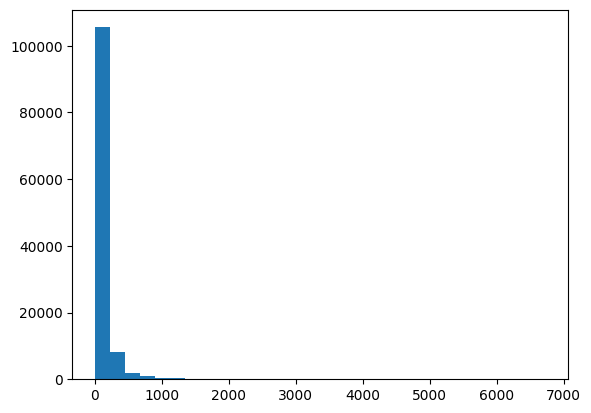

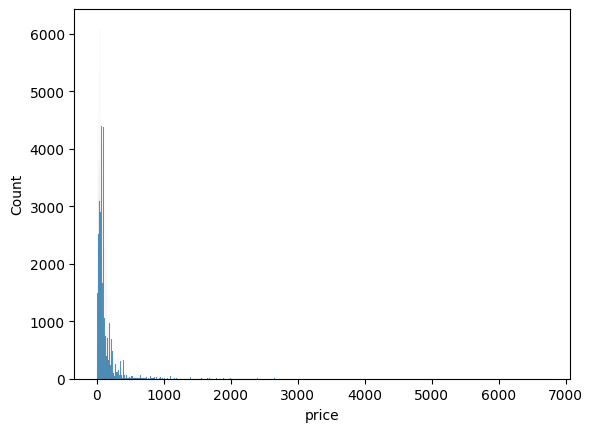

In [52]:
# Histogram versi Matplotlib (Paling sederhana)
plt.hist(df['price'], bins=30)
plt.show()

# Histogram versi Seaborn (Paling sederhana)
sns.histplot(df['price'])
plt.show()

### **Advance Version**

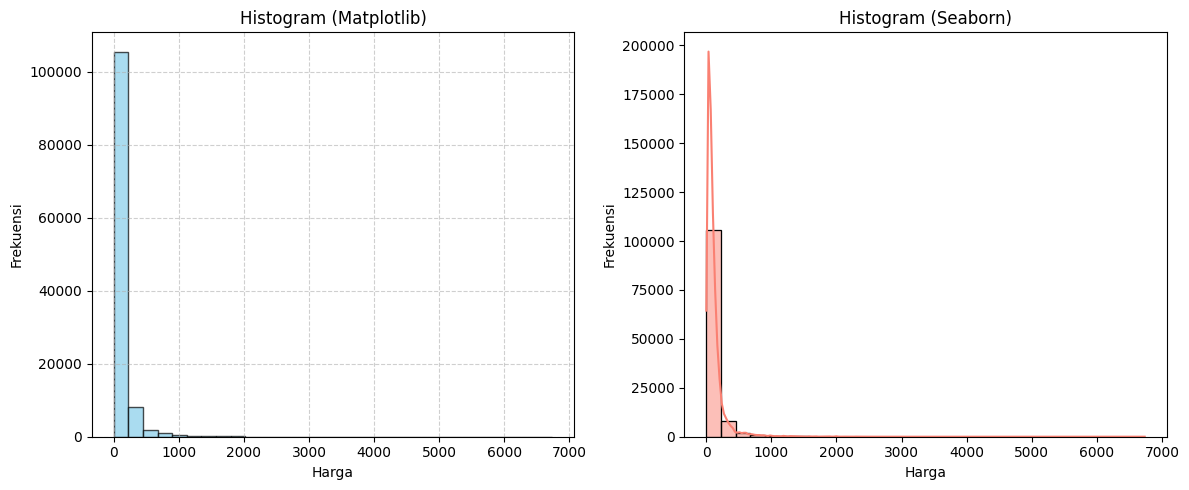

In [53]:
# Buat figure dengan 1 baris dan 2 kolom
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram versi Matplotlib
axes[0].hist(df['price'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)  # Buat histogram manual
axes[0].set_title('Histogram (Matplotlib)')  # Judul plot
axes[0].set_xlabel('Harga')  # Label sumbu X
axes[0].set_ylabel('Frekuensi')  # Label sumbu Y
axes[0].grid(True, linestyle='--', alpha=0.6)  # Tambahkan grid putus-putus

# Histogram versi Seaborn
sns.histplot(df['price'], bins=30, kde=True, color='salmon', ax=axes[1])  # Histogram dengan KDE (density curve)
axes[1].set_title('Histogram (Seaborn)')  # Judul plot
axes[1].set_xlabel('Harga')  # Label sumbu X
axes[1].set_ylabel('Frekuensi')  # Label sumbu Y

# Atur layout agar tidak saling tumpang tindih
plt.tight_layout()

# Tampilkan plot
plt.show()

### **Per Category English**

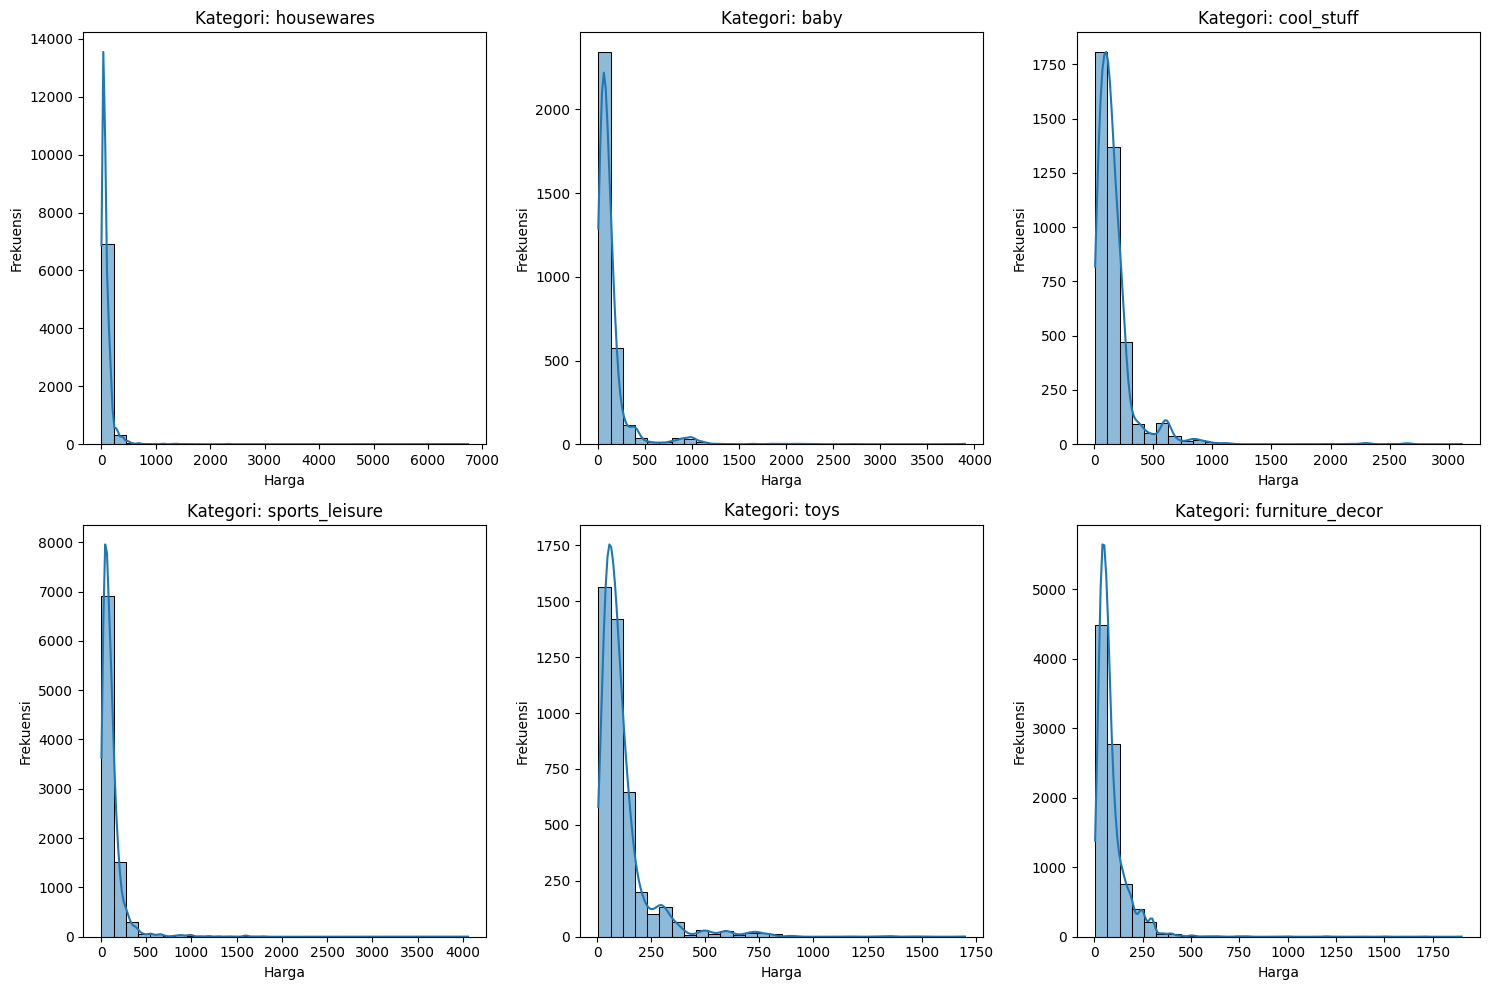

In [54]:
unique_categories = df['product_category_name_english'].unique()

# Buat figure dengan ukuran yang sesuai
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 baris, 3 kolom

# Looping untuk setiap kategori produk
for ax, category in zip(axes.flatten(), unique_categories):
    subset = df[df['product_category_name_english'] == category]  # Filter data per kategori
    
    # Buat histogram menggunakan Seaborn
    sns.histplot(subset['price'], bins=30, kde=True, ax=ax)
    
    # Set judul dan label
    ax.set_title(f'Kategori: {category}')
    ax.set_xlabel('Harga')
    ax.set_ylabel('Frekuensi')

# Atur tata letak agar tidak bertumpuk
plt.tight_layout()

# Tampilkan plot
plt.show()


## **Box Plot**
    Dalam menganalisis persebaran data, ada dua visualisasi yang sering digunakan: Histogram dan Boxplot. Keduanya punya tujuan yang mirip, yaitu untuk memahami persebaran data, tapi cara penyajiannya berbeda.

**Pengunaan Histogram**

    Histogram menampilkan jumlah data dalam rentang harga tertentu. Ini membantu menjawab pertanyaan seperti:
        1.Berapa banyak produk yang harganya di bawah Rp100?
        2.Apakah harga produk lebih sering di rentang tertentu?
        3.Apakah distribusinya normal, condong ke kanan/kiri, atau ada lonjakan harga tertentu?
    Kapan pakai histogram?
        1.Ketika ingin melihat pola umum harga
        2.Untuk mengetahui rentang harga yang paling umum
        3.Jika audiens non-teknikal, karena lebih intuitif dibanding boxplot
**Pengunaan Box Plot**

    Boxplot menampilkan ringkasan statistik harga, termasuk:
        1.Median (garis tengah di dalam kotak) → harga tengah
        2.Q1 & Q3 (batas kotak bawah & atas) → harga di 25% & 75% data
        3.Outlier (titik di luar whisker) → harga yang sangat mahal/murah dibanding kebanyakan produk
    Kapan pakai boxplot?
        1.Kalau ingin melihat sebaran harga tanpa perlu tahu jumlah pasti tiap kategori
        2.Untuk menemukan outlier (misalnya produk yang terlalu mahal atau murah)
        3.Saat membandingkan harga antar kategori produk

In [55]:
# Drop na biar ga ganggu nilai Q1 - Q3 nya
df_box_plot = df.dropna(subset=['price'])

### **Versi Gampang**

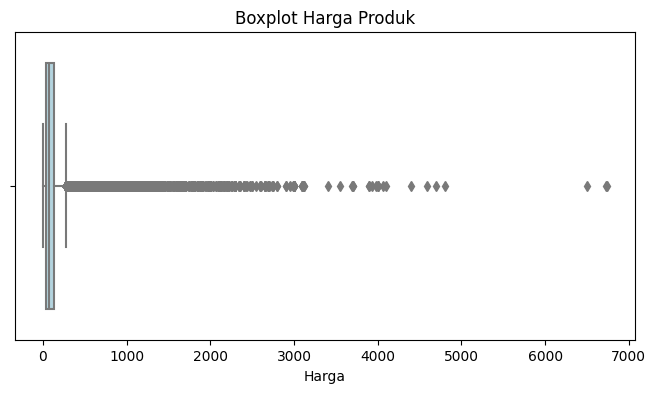

In [56]:
# Buat Boxplot horizontal (miring)
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_box_plot['price'], color='lightblue')

# Tambah judul & label
plt.title('Boxplot Harga Produk')
plt.xlabel('Harga')

# Tampilkan plot
plt.show()


### **Versi Advance**

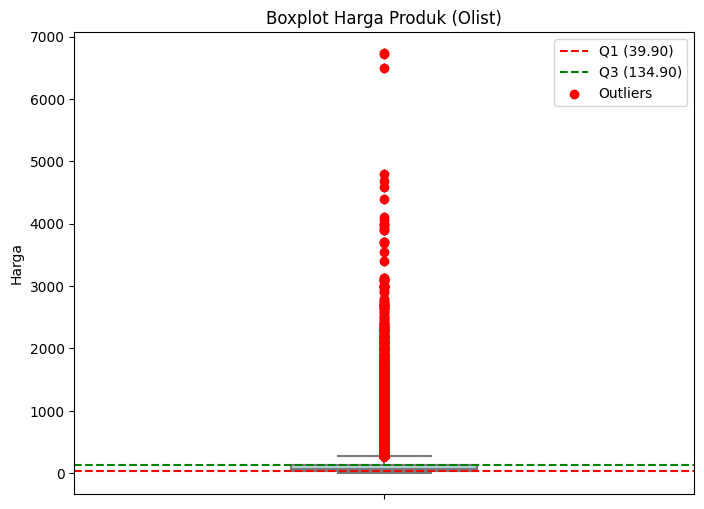

In [30]:
# Hitung Q1, Q3, dan IQR
Q1 = np.percentile(df_box_plot['price'], 25)  # Kuartil pertama (Q1)
Q3 = np.percentile(df_box_plot['price'], 75)  # Kuartil ketiga (Q3)
IQR = Q3 - Q1  # Rentang antar kuartil
lower_bound = Q1 - 1.5 * IQR  # Batas bawah untuk outlier
upper_bound = Q3 + 1.5 * IQR  # Batas atas untuk outlier

# Cari data outlier
outliers = df_box_plot[(df_box_plot['price'] < lower_bound) | (df_box_plot['price'] > upper_bound)]['price']

# Buat Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_box_plot['price'], color='lightblue', width=0.3)

# Tambahkan garis untuk Q1 dan Q3
plt.axhline(Q1, color='red', linestyle='--', label=f'Q1 ({Q1:.2f})')
plt.axhline(Q3, color='green', linestyle='--', label=f'Q3 ({Q3:.2f})')

# Tambahkan titik outlier dengan warna berbeda
plt.scatter([0] * len(outliers), outliers, color='red', label='Outliers', zorder=3)

# Tambahkan judul dan label
plt.title('Boxplot Harga Produk (Olist)')
plt.ylabel('Harga')
plt.legend()

# Tampilkan plot
plt.show()


### **Per Top 5 Category English**

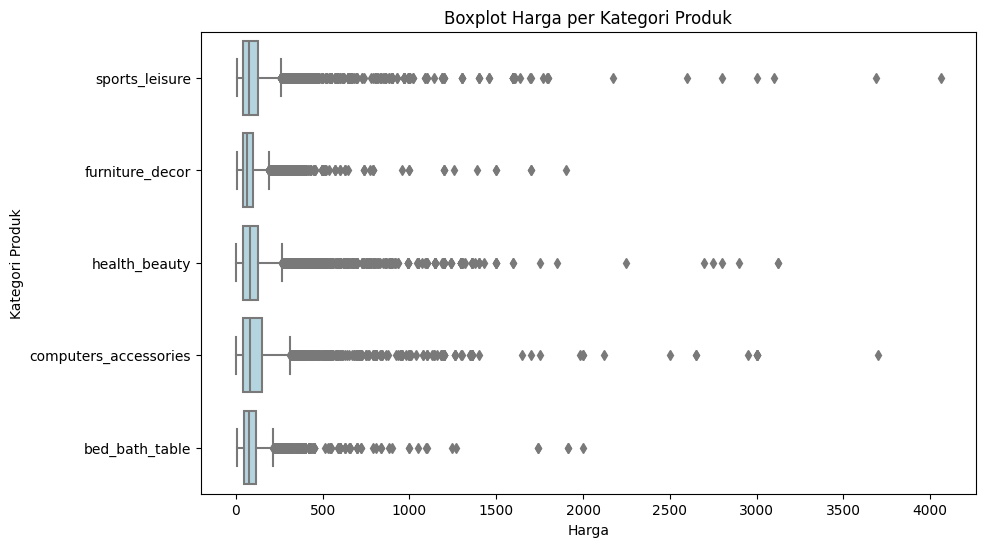

In [58]:
top_categories = df_box_plot['product_category_name_english'].value_counts().head(5).index  # Ambil 10 kategori terbanyak
df_box_plot_categories = df_box_plot[df_box_plot['product_category_name_english'].isin(top_categories)]
# Buat Boxplot per kategori
plt.figure(figsize=(10, 6))
sns.boxplot(x='price', y='product_category_name_english', data=df_box_plot_categories, color='lightblue')

# Tambah judul & label
plt.title('Boxplot Harga per Kategori Produk')
plt.xlabel('Harga')
plt.ylabel('Kategori Produk')

# Tampilkan plot
plt.show()


## **Lineplot**

    Line Plot lebih cocok buat melihat tren dari *waktu ke waktu*. Misalnya, kita bisa cek bagaimana perubahan harga rata-rata per bulan.
    Kapan Pakai Line Plot?
        1. Kalau ingin melihat tren harga dari waktu ke waktu
        2. Cocok buat data time series (misalnya harga per bulan/tahun)
        3. Mudah dimengerti, apalagi buat orang non-teknikal karena bentuknya seperti grafik tren saham

### **Versi Simpel Trendline**

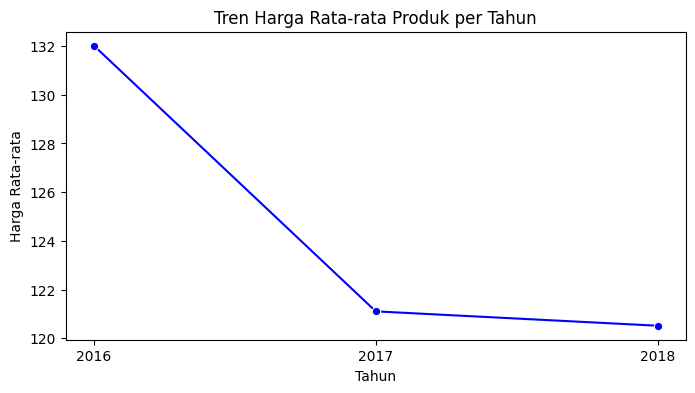

In [61]:
# Ubah ke format datetime & ambil tahunnya
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_year'] = df['order_purchase_timestamp'].dt.year

# Hitung harga rata-rata per tahun
df_avg_price = df.groupby('order_year')['price'].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.lineplot(x=df_avg_price['order_year'], y=df_avg_price['price'], marker='o', color='blue')

# Tambah judul & label
plt.title('Tren Harga Rata-rata Produk per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Harga Rata-rata')

# Paksa tahun di sumbu X jadi diskrit
plt.xticks(df_avg_price['order_year'])

# Tampilkan plot
plt.show()


### **Versi Advance**

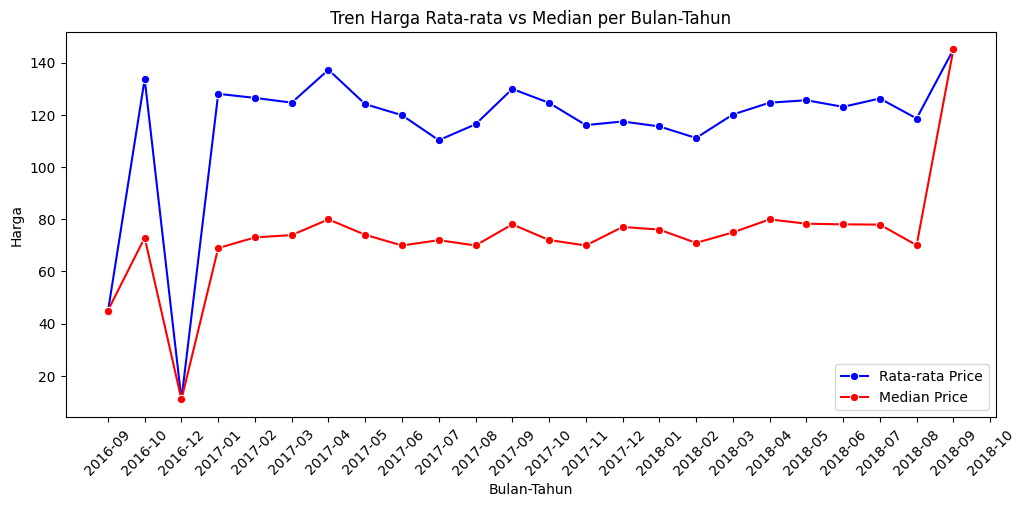

In [65]:
df['order_month_year'] = df['order_purchase_timestamp'].dt.to_period('M')  # Format YYYY-MM

# Hitung harga rata-rata & median per bulan-tahun
df_price_trend = df.groupby('order_month_year')['price'].agg(['mean', 'median']).reset_index()

# Konversi ke string biar sumbu X nggak ada angka desimal
df_price_trend['order_month_year'] = df_price_trend['order_month_year'].astype(str)

# Buat Line Plot
plt.figure(figsize=(12, 5))
sns.lineplot(x=df_price_trend['order_month_year'], y=df_price_trend['mean'], marker='o', label='Rata-rata Price', color='blue')
sns.lineplot(x=df_price_trend['order_month_year'], y=df_price_trend['median'], marker='o', label='Median Price', color='red')

# Tambah judul & label
plt.title('Tren Harga Rata-rata vs Median per Bulan-Tahun')
plt.xlabel('Bulan-Tahun')
plt.ylabel('Harga')
plt.xticks(rotation=45)  # Rotasi label biar lebih rapi
plt.legend()  # Tambah legenda

# Tampilkan plot
plt.show()

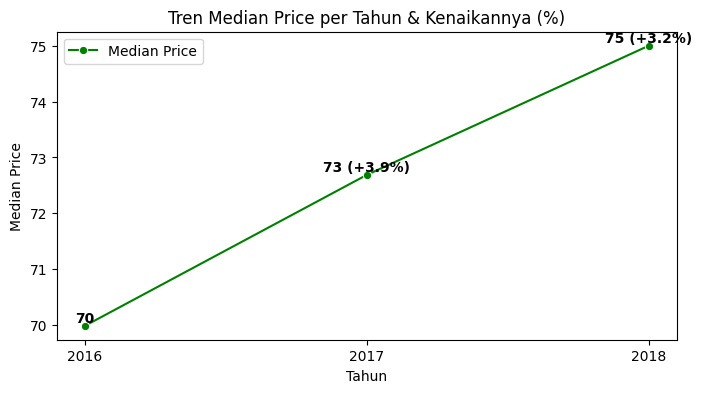

In [70]:
# Hitung median price per tahun
df_median_price = df.groupby('order_year')['price'].median().reset_index()

# Hitung persentase kenaikan dari tahun sebelumnya
df_median_price['price_change_pct'] = df_median_price['price'].pct_change() * 100  # Konversi ke %

# Buat Line Plot
plt.figure(figsize=(8, 4))
sns.lineplot(x=df_median_price['order_year'], y=df_median_price['price'], marker='o', color='green', label='Median Price')

# Tambahkan label nilai median + % perubahan di titiknya
for i in range(len(df_median_price)):
    year = df_median_price['order_year'][i]
    price = df_median_price['price'][i]
    pct_change = df_median_price['price_change_pct'][i]

    # Format teks: "median_price (+/- XX.X%)"
    if i == 0:
        text_label = f"{price:,.0f}"  # Tahun pertama ga ada % change
    else:
        sign = "+" if pct_change > 0 else ""  # Tambahkan "+" jika positif
        text_label = f"{price:,.0f} ({sign}{pct_change:.1f}%)"
    
    plt.text(year, price, text_label, ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

# Tambah judul & label
plt.title('Tren Median Price per Tahun & Kenaikannya (%)')
plt.xlabel('Tahun')
plt.ylabel('Median Price')
plt.xticks(df_median_price['order_year'])  # Pastikan sumbu X tahun utuh
plt.legend()

# Tampilkan plot
plt.show()

## **Scatter Plot**

    1. Apa Itu Scatter Plot?
    Scatter plot adalah jenis visualisasi yang menampilkan titik-titik data dalam dua dimensi. Setiap titik mewakili satu observasi, dengan sumbu X dan Y yang menunjukkan dua variabel berbeda.

    2. Fungsi Scatter Plot
        Scatter plot digunakan untuk melihat hubungan antara dua variabel. Dari grafik ini, kita bisa:
        - Mendeteksi hubungan (correlation) → Apakah ada pola antara dua variabel?
        - Mengidentifikasi outlier → Apakah ada titik data yang jauh dari pola umum?
        - Melihat distribusi data → Apakah data tersebar merata atau terkumpul di area tertentu?
    
    3. Kapan Harus Menggunakan Scatter Plot?
        - Ketika ingin melihat hubungan antar variabel numerik (contoh: harga vs biaya pengiriman).
        - Saat mengevaluasi korelasi (misal: apakah barang lebih mahal punya biaya pengiriman lebih tinggi?).
        - Jika ingin mendeteksi pola atau outlier dalam dataset.

    Note: Bisa dengan ditambah variabel categorical sebagai warna

#### **Untuk Melihat Korelasi antar kolom numerikal**
    --- df.select_dtypes(include=['number']).corr() ---

    - Jika nilai korelasi mendekati 1, berarti ada korelasi positif yang kuat → saat satu variabel naik, variabel lain juga cenderung naik.
    - Jika nilai korelasi mendekati -1, berarti ada korelasi negatif yang kuat → saat satu variabel naik, variabel lain cenderung turun.
    - Jika nilai korelasi mendekati 0, berarti tidak ada hubungan yang jelas antara kedua variabel.

In [90]:
# Contoh
df_numeric_corr = df.select_dtypes(include=['number']).corr()
df_numeric_corr


,order_item_id,price,freight_value,payment_sequential,payment_installments,payment_value,customer_zip_code_prefix,seller_zip_code_prefix,order_year
order_item_id,1.000000,-0.060497,-0.030599,-0.002393,0.073499,0.264328,0.000137,-0.018196,0.002712
price,-0.060497,1.000000,0.415813,0.006989,0.278645,0.739501,0.043325,0.088296,-0.002176
freight_value,-0.030599,0.415813,1.000000,0.023210,0.186020,0.373891,0.225468,0.152229,0.034573
payment_sequential,-0.002393,0.006989,0.023210,1.000000,-0.086129,-0.064113,-0.021231,0.014991,-0.045905
payment_installments,0.073499,0.278645,0.186020,-0.086129,1.000000,0.274107,0.056411,0.039716,-0.050322
payment_value,0.264328,0.739501,0.373891,-0.064113,0.274107,1.000000,0.054874,0.069757,0.004441
customer_zip_code_prefix,0.000137,0.043325,0.225468,-0.021231,0.056411,0.054874,1.000000,0.075528,-0.033068
seller_zip_code_prefix,-0.018196,0.088296,0.152229,0.014991,0.039716,0.069757,0.075528,1.000000,-0.013312
order_year,0.002712,-0.002176,0.034573,-0.045905,-0.050322,0.004441,-0.033068,-0.013312,1.000000


### **Versi Simpel**

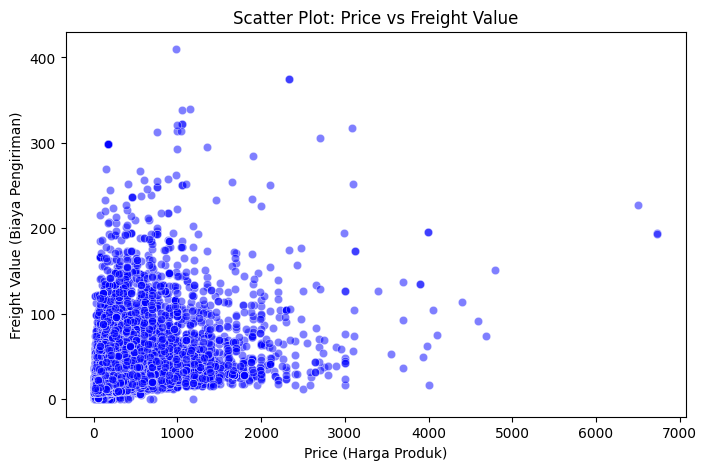

In [73]:
# Scatter Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['price'], y=df['freight_value'], alpha=0.5, color='blue')

# Tambahkan judul & label
plt.title('Scatter Plot: Price vs Freight Value')
plt.xlabel('Price (Harga Produk)')
plt.ylabel('Freight Value (Biaya Pengiriman)')
plt.show()

### **Advanced**

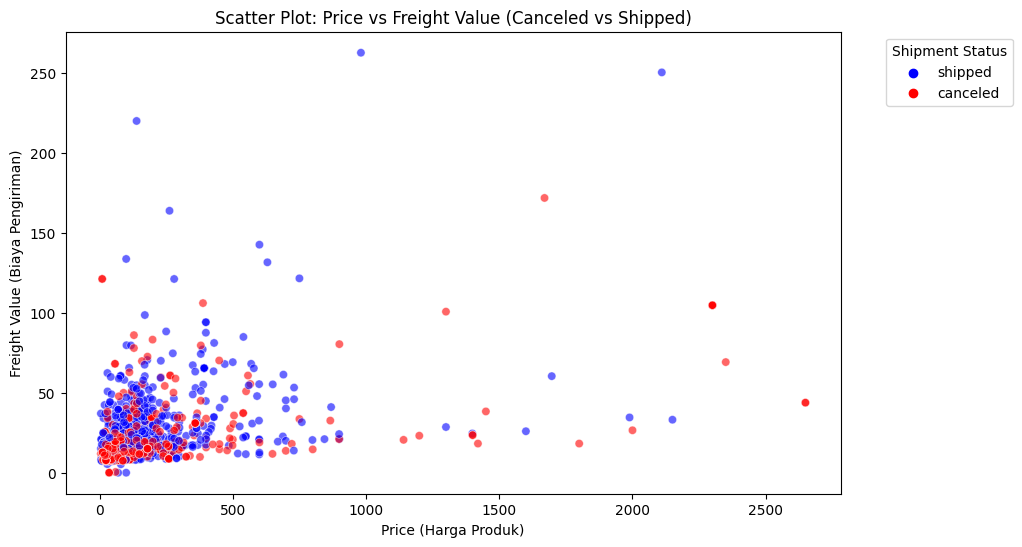

In [79]:
# Filter hanya untuk order_status "canceled" dan "shipped"
df_filtered = df_box_plot[df_box_plot['order_status'].isin(['canceled', 'shipped'])]

# Buat scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df_filtered['price'], 
    y=df_filtered['freight_value'], 
    hue=df_filtered['order_status'],  # Warna hanya untuk canceled & shipped
    alpha=0.6,
    palette={'canceled': 'red', 'shipped': 'blue'}  # Warna khusus biar jelas
)

# Tambahkan judul & label
plt.title('Scatter Plot: Price vs Freight Value (Canceled vs Shipped)')
plt.xlabel('Price (Harga Produk)')
plt.ylabel('Freight Value (Biaya Pengiriman)')
plt.legend(title='Shipment Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### **Jika ada korelasi**

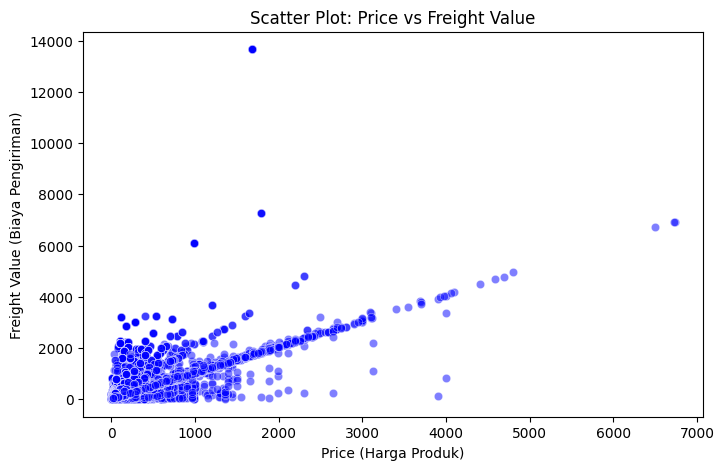

In [86]:
# Scatter Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['price'], y=df['payment_value'], alpha=0.5, color='blue')

# Tambahkan judul & label
plt.title('Scatter Plot: Price vs Freight Value')
plt.xlabel('Price (Harga Produk)')
plt.ylabel('Freight Value (Biaya Pengiriman)')
plt.show()